In [1]:
import tensorflow as tf
print(tf.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

2.15.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
shakespeare_dataset = pd.read_csv("/content/drive/MyDrive/final1.csv")

In [4]:
shakespeare_dataset.head()

,Unnamed: 0,id,og,t
0,0.0,42928-1500614319216-63344,You do not meet a man but frowns:,Every man you meet these days is frowning.
1,NaN,NaN,shorten,abate
2,1.0,42928-1500614326583-89821,blunt,abate
3,2.0,A-63849,diminution,abatement
4,3.0,42930-1500614347266-80123,protest,abhor


In [5]:
shakespeare_dataset.drop(columns=['id','Unnamed: 0'],inplace=True)

In [6]:
shakespeare_dataset.head()

,og,t
0,You do not meet a man but frowns:,Every man you meet these days is frowning.
1,shorten,abate
2,blunt,abate
3,diminution,abatement
4,protest,abhor


In [7]:
shakespeare_dataset.tail()

,og,t
51783,He hath not told us of the captain yet.,He hasn't told us about that captain yet.
51784,"When that is known and golden time convents, ...",When that's taken care of and the time is conv...
51785,"Meantime, sweet sister, We will not part fro...","Until then, sweet sister-in-law, we won't leav..."
51786,"Cesario, come, For so you shall be, while yo...","Cesario, come here. You'll be Cesario to me wh..."
51787,"When that I was and a little tiny boy, With...","When I was just a tiny little boy,With hey, ho..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [8]:

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def preprocess_sentences(w):
  w = unicode_to_ascii(w.lower().strip())

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿:;])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",","¿")
  w = re.sub(r"[^a-zA-Z?.!,¿:;]+", " ", w)

    # remove extra space
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w


In [9]:
og_sent = shakespeare_dataset['og'][0]
t_sent = shakespeare_dataset['t'][0]

print(preprocess_sentence(og_sent))
print(preprocess_sentence(t_sent))
print(preprocess_sentence(t_sent).encode("UTF-8"))

<start> you do not meet a man but frowns : <end>
<start> every man you meet these days is frowning . <end>
b'<start> every man you meet these days is frowning . <end>'


In [10]:
# Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(data):
  sh_eng = [preprocess_sentence(og_sent) for og_sent in data['og'][:10000]]
  mo_eng = [preprocess_sentence(t_sent) for t_sent in data['t'][:10000]]
  return sh_eng,mo_eng
sh_eng, mo_eng = create_dataset(shakespeare_dataset)
print(sh_eng[-1])
print(mo_eng[-1])
print(len(sh_eng), len(mo_eng))

<start> provided that none but i and my companion maid be suffer d to come near him . <end>
<start> as long as no one but me and my maid are allowed to come near him . <end>
10000 10000


In [11]:
# Tokenize the sentence into list of words(integers) and pad the sequence to the same length
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [12]:
def load_dataset(data):
  sh_eng, mo_eng = create_dataset(data)
  input_tensor, inp_lang_tokenizer = tokenize(sh_eng)
  target_tensor, targ_lang_tokenizer = tokenize(mo_eng)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(shakespeare_dataset)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

104 89


In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
print(input_tensor_train[0])
print(target_tensor_train[0])

8000 8000 2000 2000
[   2   16   24  412    1  154   15    1   14   38   91 1343    1  136
   15    1   26   87 1468    6   10  468    6   10 5479 2363    1 8908
  152  679    1   57   17    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[   2   14   17  167    1   38    7  116    1   12   32  101  236    1
   73    1   24   95 1436    6   11  572    6   11 2806 1335    1   92
   20  591   19    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0

In [15]:
# Configuration
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
steps_per_epoch_val = len(input_tensor_val)//BATCH_SIZE
embedding_dim = 128  # for word embedding
units = 1024  # dimensionality of the output space of RNN
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

# Define regularization parameter
l2_reg = 0.001

In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                                   embeddings_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.dropout = tf.keras.layers.Dropout(0.3)

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (32, 89, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                                   embeddings_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
        self.dropout = tf.keras.layers.Dropout(0.3)

    def call(self, x, hidden):
        x = self.embedding(x)
        x = self.dropout(x)
        output, state = self.gru(x, initial_state=hidden)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state


In [19]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 9481)


In [20]:
class DotProductAttention(tf.keras.layers.Layer):
  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # inner product, score shape == (batch_size, max_length, 1)
    score = query_with_time_axis * values
    score = tf.reduce_sum(score, axis=2)
    score = tf.expand_dims(score, 2)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
attention_layer = DotProductAttention()
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 89, 1)


In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [23]:
class DecoderWithAttention(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, attention_layer = None):
    super(DecoderWithAttention, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.dropout = tf.keras.layers.Dropout(0.3)

    # used for attention
    self.attention = attention_layer

  def call(self, x, hidden, enc_output):
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    x = self.dropout(x)
    attention_weights = None

    if self.attention:
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)
      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state = hidden)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

In [25]:
print(loss_object([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))
print(loss_function([1,2],[[0,0.6,0.3,0.1],[0,0.6,0.3,0.1]]))

tf.Tensor([1.063386  1.3633859], shape=(2,), dtype=float32)
tf.Tensor(1.2133859, shape=(), dtype=float32)


In [26]:
optimizer = tf.keras.optimizers.legacy.Adam()

def get_train_step_func():

  @tf.function
  def train_step(inp, targ, enc_hidden, encoder, decoder):
    loss = 0

    with tf.GradientTape() as tape: # for automatic differentiation
      enc_output, enc_hidden = encoder(inp, enc_hidden)

      dec_hidden = enc_hidden

      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

      # Teacher forcing - feeding the target as the next input
      for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

  return train_step


In [27]:
def caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder):
  loss = 0
  enc_output, enc_hidden = encoder(inp, enc_hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    loss += loss_function(targ[:, t], predictions)
    dec_input = tf.expand_dims(targ[:, t], 1)

  loss = loss / int(targ.shape[1])
  return loss

In [28]:
def training_seq2seq(epochs, attention):
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
  decoder = DecoderWithAttention(vocab_tar_size, embedding_dim, units, BATCH_SIZE, attention)
  train_step_func = get_train_step_func()
  training_loss = []
  validation_loss = []

  for epoch in range(epochs):
    start = time.time()
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
      batch_loss = train_step_func(inp, targ, enc_hidden, encoder, decoder)
      total_loss += batch_loss

      if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))

    enc_hidden = encoder.initialize_hidden_state()
    total_val_loss = 0
    for (batch, (inp, targ)) in enumerate(validation_dataset.take(steps_per_epoch)):
      val_loss = caculate_validation_loss(inp, targ, enc_hidden, encoder, decoder)
      total_val_loss += val_loss

    training_loss.append(total_loss / steps_per_epoch)
    validation_loss.append(total_val_loss / steps_per_epoch_val)
    print('Epoch {} Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                        training_loss[-1], validation_loss[-1]))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
  return encoder, decoder, training_loss, validation_loss

In [29]:
epochs = 10

attention = BahdanauAttention(units)
print("Running seq2seq model with Bahdanau attention")
encoder_bah, decoder_bah, training_loss, validation_loss = training_seq2seq(epochs, attention)

Running seq2seq model with Bahdanau attention
Epoch 1 Batch 0 Loss 1.7582
Epoch 1 Batch 100 Loss 1.2579
Epoch 1 Batch 200 Loss 1.1572
Epoch 1 Loss 1.1451 Validation Loss 1.1714
Time taken for 1 epoch 475.64580631256104 sec

Epoch 2 Batch 0 Loss 1.2794
Epoch 2 Batch 100 Loss 0.9525
Epoch 2 Batch 200 Loss 0.8089
Epoch 2 Loss 1.0223 Validation Loss 0.9653
Time taken for 1 epoch 382.61306977272034 sec

Epoch 3 Batch 0 Loss 0.8527
Epoch 3 Batch 100 Loss 0.8120
Epoch 3 Batch 200 Loss 0.8194
Epoch 3 Loss 0.8754 Validation Loss 0.9062
Time taken for 1 epoch 385.7106502056122 sec

Epoch 4 Batch 0 Loss 0.8289
Epoch 4 Batch 100 Loss 0.8538
Epoch 4 Batch 200 Loss 0.7947
Epoch 4 Loss 0.8022 Validation Loss 0.8927
Time taken for 1 epoch 352.9560983181 sec

Epoch 5 Batch 0 Loss 0.8115
Epoch 5 Batch 100 Loss 0.6810
Epoch 5 Batch 200 Loss 0.7544
Epoch 5 Loss 0.7321 Validation Loss 0.8847
Time taken for 1 epoch 350.64090847969055 sec

Epoch 6 Batch 0 Loss 0.5978
Epoch 6 Batch 100 Loss 0.7650
Epoch 6 Bat

In [30]:
tloss = training_loss
vloss = validation_loss

Text(0.5, 1.0, 'Validation loss')

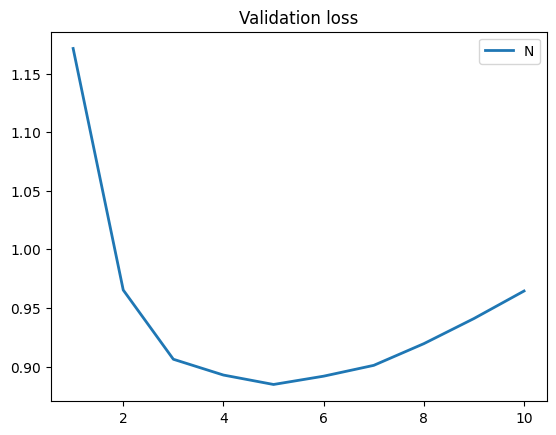

In [31]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)
t = np.arange(1, epochs+1)

line, = plt.plot(t, vloss, lw=2)

ax.legend(('No attention'))
ax.set_title("Validation loss")

In [38]:
def translate(sentence, encoder, decoder):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    # until the predicted word is <end>.
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model, no teacher forcing.
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [53]:
# Initialize a list of sentences
sentences = [
    u"Alack, the king!",
    u"I humbly thank your highness.",
    u"Pardon, dear madam:"
]

# Iterate over the sentences and generate translations
for idx, sentence in enumerate(sentences):
    result, _ = translate(sentence, encoder_bah, decoder_bah)
    print('Input {}: {}'.format(idx + 1, sentence))
    print('Predicted translation: {}'.format(result))


Input 1: Pardon, dear madam:
Predicted translation: please , listen , sir . <end> 


In [35]:
import tensorflow as tf

# Assuming you have 'encoder_model' and 'decoder_model' as your encoder and decoder models

# Save encoder model
tf.saved_model.save(encoder_bah, './content/drive/MyDrive/encoder')

# Save decoder model
tf.saved_model.save(decoder_bah, './content/drive/MyDrive/decoder')

In [51]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

# Initialize a list of sentences and their corresponding reference translations
sentences = [
    u"Alack, the king!",
    u"I humbly thank your highness.",
    u"Pardon, dear madam:"
]

# Manually specify the reference translations
references = [
    ["Hail, King"],
    ["I thank you humbly, your highness"],
    ["Excuse me, dear madam."]
]

# Initialize a list to store the translations
translations = []

# Iterate over the sentences and generate translations
for idx, sentence in enumerate(sentences):
    # Translate the sentence using your encoder and decoder
    result, _ = translate(sentence, encoder_bah, decoder_bah)
    translations.append(result.split())
    print('Input {}: {}'.format(idx + 1, sentence))
    print('Predicted translation: {}'.format(result))

# Calculate BLEU score for the corpus
bleu_score = corpus_bleu(references, translations)
print("BLEU Score:", bleu_score)


Input 1: Alack, the king!
Predicted translation: hail , king ! <end> 
Input 2: I humbly thank your highness.
Predicted translation: i thank you , sir . <end> 
Input 3: Pardon, dear madam:
Predicted translation: please , listen , sir . <end> 
BLEU Score: 1.1590779022541725e-232


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_